# Complete RaTag Analysis Pipeline - OPTIMIZED VERSION

This notebook demonstrates the **optimized unified pipeline** with ~50% time savings.

## Key Improvements

1. **Unified Integration**: X-ray classification + S2 integration in SINGLE pass (2 hours instead of 4)
2. **Fast S2 Window Estimation**: Uses only 2k waveforms instead of all 100k (~5 min instead of 30 min)
3. **Same Output**: Identical results to original pipeline, fully compatible

## Workflow

1. **Prepare Run**: Load data, estimate S1 times, compute fields (with fast S2 window estimation)
2. **Unified Integration**: X-ray classification + S2 integration in one pass ⚡
3. **S2 Fitting**: Fast post-processing (no waveform loading)
4. **Calibration**: Energy calibration and recombination analysis

**Total Time**: ~2.1 hours (vs ~4.5 hours for separate workflows)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from RaTag.datatypes import Run
from RaTag.config import IntegrationConfig, FitConfig
from RaTag.pipeline_optimized import (
    prepare_run_optimized,
    run_unified_integration,
    run_s2_fitting,
    run_calibration_analysis_optimized
)
import RaTag.plotting as plotting

%matplotlib inline

## 1. Define Run Parameters

In [4]:
# Set data directory
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN12_Po216')

# Define run parameters
run12 = Run(
    root_directory = base_dir,
    run_id = "RUN12",
    el_field = 2375,            # V/cm
    target_isotope = "Po216",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,        # Hz (5 GS/s for FastFrame)
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm
    width_s2 = 20,              # µs
    
    # Calibration constants
    W_value = 22.0,             # eV per e-ion pair (Xe @ 2 bar)
    E_gamma_xray = 11.7e3,      # eV (Ra-224 X-ray energy)
)

## 2. Prepare Run (OPTIMIZED)

**Key optimization**: S2 window estimation uses only **500 waveforms** instead of all ~100k

This step:
- Computes gas density from pressure/temperature
- Loads all measurement sets from directory structure
- Estimates S1 time for each set
- **Estimates S2 timing windows from 500 waveforms per set** (fast!)
- Computes drift/EL fields and transport properties

**Time**: ~1 minutes (vs ~30 minutes in old pipeline)

In [18]:
# Prepare run with optimized S2 window estimation
run12 = prepare_run_optimized(
    run12,
    flag_plot=False,
    max_frames_s1=200,     
    threshold_s1=1.2,
    estimate_s2_windows=True,
    max_frames_s2=200,    
    s2_duration_cuts=(5, 25),
    threshold_s2=2.0
)

PREPARING RUN (OPTIMIZED): RUN12

[1/4] Gas density: 4.877e+19 cm⁻³
  Loaded: FieldScan_Gate0050_Anode1950 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0100_Anode2000 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0200_Anode2100 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0300_Anode2200 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0400_Anode2300 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0500_Anode2400 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0600_Anode2500 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0800_Anode2700 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate1000_Anode2900 - 2000 files (96000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate1200_Anode3100 - 

In [17]:
# Inspect prepared sets
print(f"Prepared {len(run12.sets)} sets:\n")
for i, s in enumerate(run12.sets):
    print(f"Set {i}: {s.source_dir.name}")
    print(f"  t_s1: ({s.metadata['t_s1']:.3f} ± {s.metadata['t_s1_std']:.3f}) µs")
    print(f"  Drift field: {s.drift_field:.1f} V/cm")
    print(f"  Drift time: {s.time_drift:.3f} µs")
    
    # Show S2 window if estimated
    if 't_s2_start_mean' in s.metadata:
        print(f"  S2 window: [{s.metadata['t_s2_start_mean']:.2f}, {s.metadata['t_s2_end_mean']:.2f}] µs")
        print(f"  S2 duration: {s.metadata['s2_duration_mean']:.2f} ± {s.metadata['s2_duration_std']:.2f} µs")
    print()

Prepared 14 sets:

Set 0: FieldScan_Gate0050_Anode1950
  t_s1: (-3.190 ± 3.726) µs
  Drift field: 35.7 V/cm
  Drift time: 19.976 µs

Set 1: FieldScan_Gate0100_Anode2000
  t_s1: (-3.006 ± 3.898) µs
  Drift field: 71.4 V/cm
  Drift time: 15.138 µs

Set 2: FieldScan_Gate0200_Anode2100
  t_s1: (-3.057 ± 3.728) µs
  Drift field: 142.9 V/cm
  Drift time: 13.210 µs

Set 3: FieldScan_Gate0300_Anode2200
  t_s1: (-2.993 ± 3.697) µs
  Drift field: 214.3 V/cm
  Drift time: 12.431 µs

Set 4: FieldScan_Gate0400_Anode2300
  t_s1: (-3.175 ± 3.626) µs
  Drift field: 285.7 V/cm
  Drift time: 11.835 µs

Set 5: FieldScan_Gate0500_Anode2400
  t_s1: (-3.027 ± 3.949) µs
  Drift field: 357.1 V/cm
  Drift time: 11.334 µs

Set 6: FieldScan_Gate0600_Anode2500
  t_s1: (-3.113 ± 1.731) µs
  Drift field: 428.6 V/cm
  Drift time: 10.905 µs

Set 7: FieldScan_Gate0800_Anode2700
  t_s1: (-2.871 ± 3.971) µs
  Drift field: 571.4 V/cm
  Drift time: 10.208 µs

Set 8: FieldScan_Gate1000_Anode2900
  t_s1: (-3.165 ± 3.935) µs

### Optional: Manual Adjustment of S1 Times

If automatic S1 estimation is off for some sets, adjust manually:

In [47]:
# Example: adjust S1 time for specific sets if needed
# from dataclasses import replace
# adjusted_sets = []
# for s in run10.sets:
#     print('Set: ', s.source_dir.name, ' t_s1 = ', s.metadata['t_s1'], ' ± ', s.metadata['t_s1_std'])
#     if s.metadata['t_s1'] > - 1.0:
#         print('  --> High S1 time, adjusting t_s1 manually.')
#         s = replace(s, metadata={**s.metadata, 't_s1': -2.86, 't_s1_std': 2.2})
#     adjusted_sets.append(s)
    
# run10 = replace(run10, sets=adjusted_sets)

### Visualize S2 Windows

Check that S2 integration windows are correctly positioned:

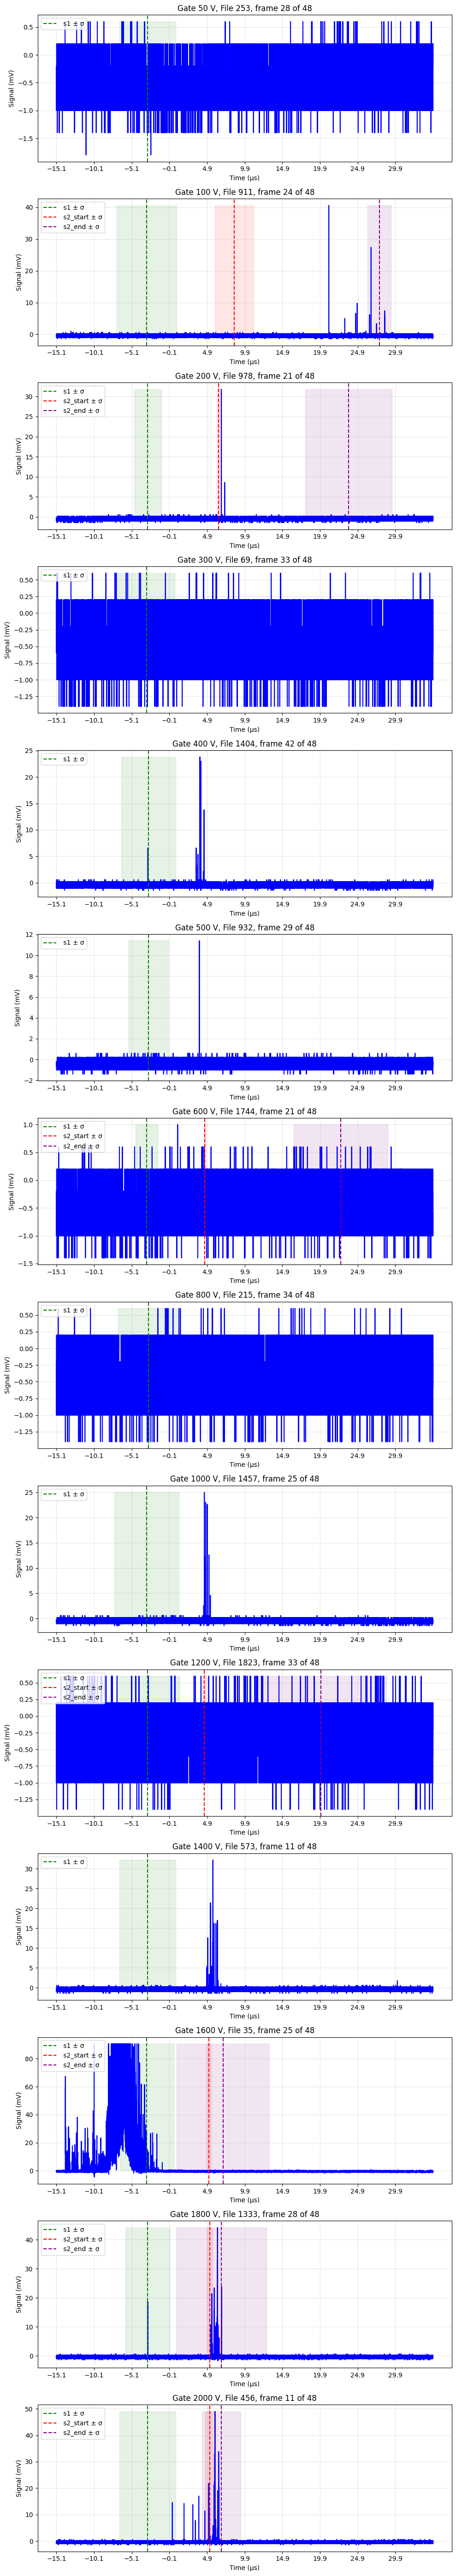

In [19]:
# Plot S2 windows for visual verification
fig, ax = plt.subplots(len(run12.sets), figsize=(10, 4*len(run12.sets)))
for i,s in enumerate(run12.sets):
    plotting.plot_set_windows(s, ax=ax[i])

## 3. Unified Integration (MAJOR OPTIMIZATION)

**This is the key optimization!** 

Instead of running X-ray classification and S2 integration separately (each taking ~2 hours), we process both **in a single pass** over all waveforms.

**What happens here**:
1. Load each waveform once
2. Preprocess once (unit conversion, pedestal subtraction, moving average, threshold clip)
3. Extract X-ray window → classify
4. Extract S2 window → integrate
5. Save both results

**Time**: ~2 hours (vs ~4 hours for separate workflows)  
**Speedup**: 2× faster!

### Testing Mode

For quick testing, uncomment the `nfiles=10` parameter below to process only 20 files per set (~1 minutes total).

In [20]:
# Define integration configurations
xray_config = IntegrationConfig(
    bs_threshold = 0.5,        # mV
    n_pedestal = 200,          # samples
    ma_window = 10,            # samples
    dt = 2e-4,                 # µs
)

ion_config = IntegrationConfig(
    bs_threshold = 0.8,        # mV
    n_pedestal = 2000,         # samples
    ma_window = 9,             # samples
    dt = 2e-4,                 # µs
)

In [21]:
# UNIFIED INTEGRATION: X-ray classification + S2 integration in SINGLE PASS
xray_results, s2_areas = run_unified_integration(
    run12,
    ts2_tol=-2.7,
    xray_config=xray_config,
    ion_config=ion_config,
    use_estimated_s2_windows=True,
    max_frames=1000  # Set to ~2000 for testing, None for full run
)

print("\n✓ Unified integration complete!")
print(f"✓ Processed {len(s2_areas)} sets in SINGLE pass")
print("✓ X-ray results saved: xray_results.json, xray_areas.npy")
print("✓ S2 results saved: s2_areas.npy, s2_results.json")

⚠ TEST MODE: limiting to ~1000 frames per set (21 files, ~1008 actual frames)
   For production, run without max_frames parameter to process all files

UNIFIED INTEGRATION: X-RAY CLASSIFICATION + S2 AREAS
Processing 14 sets with SINGLE pass over waveforms

[1/14] Processing: FieldScan_Gate0050_Anode1950
  → Using tS1: [-3.00 ± 3.75] µs
  → Using offset-based S2 window: [14.28, 64.28] µs
  → X-rays: 101/1008 accepted (10.0%)
  → S2 areas: 1008 integrated
  → Saved: xray_results.json, xray_areas.npy, s2_areas.npy, s2_results.json

[2/14] Processing: FieldScan_Gate0100_Anode2000
  → Using tS1: [-3.12 ± 3.96] µs
  → Using estimated S2 window: [5.79, 27.76] µs
  → X-rays: 123/1008 accepted (12.2%)
  → S2 areas: 1008 integrated
  → Saved: xray_results.json, xray_areas.npy, s2_areas.npy, s2_results.json

[3/14] Processing: FieldScan_Gate0200_Anode2100
  → Using tS1: [-2.99 ± 1.81] µs
  → Using estimated S2 window: [3.72, 23.70] µs
  → X-rays: 100/1008 accepted (9.9%)
  → S2 areas: 1008 integr

### Check Results

Verify that both X-ray and S2 data were collected:

In [22]:
# Check X-ray classification results
print("X-ray Classification Summary:\n")
for set_name, xray_result in xray_results.items():
    n_accepted = sum(1 for e in xray_result.events if e.accepted)
    n_total = len(xray_result.events)
    print(f"{set_name}:")
    print(f"  {n_accepted}/{n_total} events accepted ({100*n_accepted/n_total:.1f}%)")

X-ray Classification Summary:

FieldScan_Gate0050_Anode1950:
  101/1008 events accepted (10.0%)
FieldScan_Gate0100_Anode2000:
  123/1008 events accepted (12.2%)
FieldScan_Gate0200_Anode2100:
  100/1008 events accepted (9.9%)
FieldScan_Gate0300_Anode2200:
  199/1008 events accepted (19.7%)
FieldScan_Gate0400_Anode2300:
  106/1008 events accepted (10.5%)
FieldScan_Gate0500_Anode2400:
  92/1008 events accepted (9.1%)
FieldScan_Gate0600_Anode2500:
  124/1008 events accepted (12.3%)
FieldScan_Gate0800_Anode2700:
  50/1008 events accepted (5.0%)
FieldScan_Gate1000_Anode2900:
  109/1008 events accepted (10.8%)
FieldScan_Gate1200_Anode3100:
  96/1008 events accepted (9.5%)
FieldScan_Gate1400_Anode3300:
  130/1008 events accepted (12.9%)
FieldScan_Gate1600_Anode3500:
  122/1008 events accepted (12.1%)
FieldScan_Gate1800_Anode3700:
  159/1008 events accepted (15.8%)
FieldScan_Gate2000_Anode3900:
  112/1008 events accepted (11.1%)


In [53]:
# Check S2 integration results
print("\nS2 Integration Summary:\n")
for set_name, s2_result in s2_areas.items():
    n_areas = len(s2_result.areas)
    valid_areas = s2_result.areas[~np.isnan(s2_result.areas)]
    print(f"{set_name}:")
    print(f"  {len(valid_areas)}/{n_areas} valid S2 areas")
    print(f"  Mean: {np.mean(valid_areas):.3f} mV·µs")
    print(f"  Std: {np.std(valid_areas):.3f} mV·µs")


S2 Integration Summary:

FieldScan_Gate050_Anode1950:
  2016/2016 valid S2 areas
  Mean: 5.362 mV·µs
  Std: 46.218 mV·µs
FieldScan_Gate1000_Anode2900:
  2016/2016 valid S2 areas
  Mean: 2.749 mV·µs
  Std: 13.168 mV·µs
FieldScan_Gate100_Anode2000:
  2016/2016 valid S2 areas
  Mean: 3.463 mV·µs
  Std: 26.636 mV·µs
FieldScan_Gate1200_Anode3100:
  2016/2016 valid S2 areas
  Mean: 3.234 mV·µs
  Std: 14.298 mV·µs
FieldScan_Gate1500_Anode3400:
  2016/2016 valid S2 areas
  Mean: 2.544 mV·µs
  Std: 11.956 mV·µs
FieldScan_Gate1800_Anode3700:
  2016/2016 valid S2 areas
  Mean: 1.992 mV·µs
  Std: 9.388 mV·µs
FieldScan_Gate200_Anode2100:
  2016/2016 valid S2 areas
  Mean: 4.344 mV·µs
  Std: 26.906 mV·µs
FieldScan_Gate400_Anode2300:
  2016/2016 valid S2 areas
  Mean: 2.898 mV·µs
  Std: 17.157 mV·µs
FieldScan_Gate600_Anode2500:
  2016/2016 valid S2 areas
  Mean: 2.915 mV·µs
  Std: 14.428 mV·µs
FieldScan_Gate800_Anode2700:
  2016/2016 valid S2 areas
  Mean: 3.037 mV·µs
  Std: 15.028 mV·µs


## 4. S2 Fitting (Fast Post-Processing)

Fit Gaussian distributions to the S2 area histograms.

**This is fast** (~1 minute) because it only fits already-integrated data, no waveform loading.

In [54]:
# Define fitting configuration
fit_config = FitConfig(
    bin_cuts = (0, 10),        # mV·µs
    nbins = 100,
    exclude_index = 2,         # Skip first 2 bins (pedestal)
)

In [55]:
# Fit S2 distributions
s2_fitted = run_s2_fitting(
    run10,
    s2_areas,
    fit_config=fit_config,
    flag_plot=False,      # Set to True to display plots interactively
    save_plots=True       # Save plots to disk
)

print("\n✓ S2 fitting complete!")
print("✓ Plots saved to plots/ directory")

FITTING S2 DISTRIBUTIONS

Generating and saving plots...
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/plots/FieldScan_Gate050_Anode1950_s2_histogram.png
Averaging FastFrame waveform for plotting
y_max: 8.20 V
Averaging FastFrame waveform for plotting
y_max: 37.80 V
Averaging FastFrame waveform for plotting
y_max: 41.80 V
Averaging FastFrame waveform for plotting
y_max: 0.60 V
Averaging FastFrame waveform for plotting
y_max: 22.60 V
Averaging FastFrame waveform for plotting
y_max: 23.40 V
Averaging FastFrame waveform for plotting
y_max: 52.20 V
Averaging FastFrame waveform for plotting
y_max: 0.60 V
Averaging FastFrame waveform for plotting
y_max: 39.00 V
Averaging FastFrame waveform for plotting
y_max: 90.60 V
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/plots/FieldScan_Gate050_Anode1950_waveform_validation.png
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN10_Ra226/plots/FieldScan_Gate1000_Anode2900_s2_histogram.png
Averaging FastFrame waveform for plotting
y_max: 35.00 V
Av

### Visualize S2 Fits

In [56]:
# Display fit results
print("S2 Gaussian Fit Results:\n")
for set_name, fit in s2_fitted.items():
    if fit.fit_success:
        print(f"{set_name}:")
        print(f"  Mean: {fit.mean:.3f} ± {fit.ci95:.3f} mV·µs")
        print(f"  Sigma: {fit.sigma:.3f} mV·µs")
    else:
        print(f"{set_name}: Fit failed")

S2 Gaussian Fit Results:

FieldScan_Gate050_Anode1950:
  Mean: 0.521 ± 0.057 mV·µs
  Sigma: 0.755 mV·µs
FieldScan_Gate1000_Anode2900:
  Mean: 1.705 ± 0.068 mV·µs
  Sigma: 1.289 mV·µs
FieldScan_Gate100_Anode2000:
  Mean: 0.930 ± 0.062 mV·µs
  Sigma: 0.922 mV·µs
FieldScan_Gate1200_Anode3100:
  Mean: 1.396 ± 0.097 mV·µs
  Sigma: 1.381 mV·µs
FieldScan_Gate1500_Anode3400:
  Mean: 1.551 ± 0.082 mV·µs
  Sigma: 1.286 mV·µs
FieldScan_Gate1800_Anode3700:
  Mean: 1.011 ± 0.042 mV·µs
  Sigma: 0.937 mV·µs
FieldScan_Gate200_Anode2100:
  Mean: 1.376 ± 0.047 mV·µs
  Sigma: 1.018 mV·µs
FieldScan_Gate400_Anode2300:
  Mean: 1.711 ± 0.075 mV·µs
  Sigma: 1.241 mV·µs
FieldScan_Gate600_Anode2500:
  Mean: 1.725 ± 0.116 mV·µs
  Sigma: 1.486 mV·µs
FieldScan_Gate800_Anode2700:
  Mean: 1.855 ± 0.107 mV·µs
  Sigma: 1.422 mV·µs


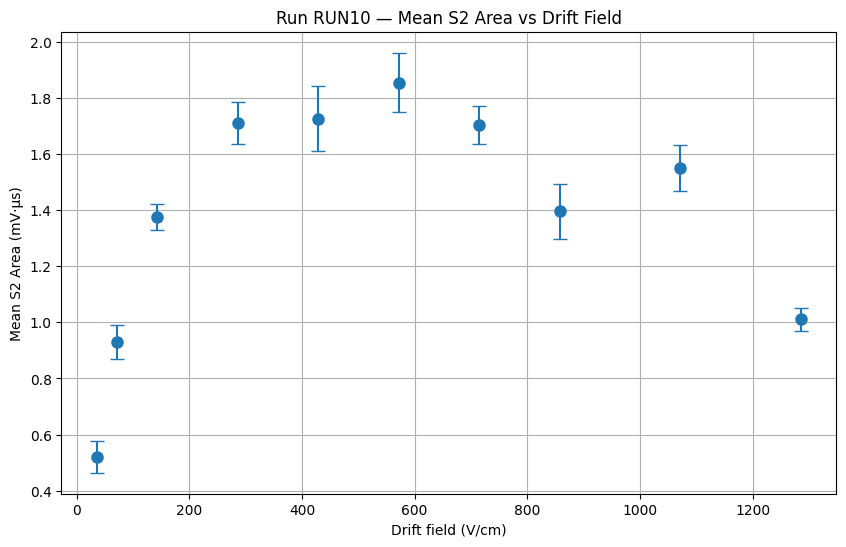

In [57]:
# Plot S2 vs drift field
fig, ax = plotting.plot_s2_vs_drift(run10, s2_fitted, normalized=False)
plt.show()

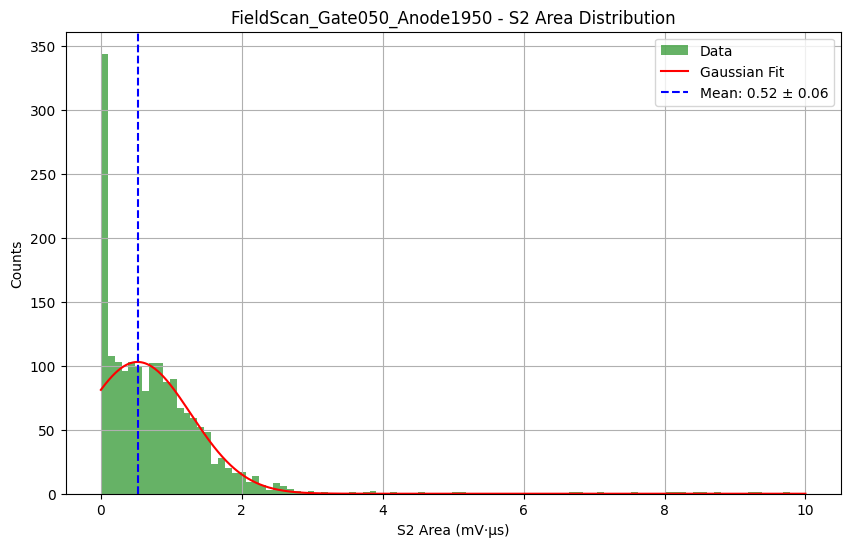

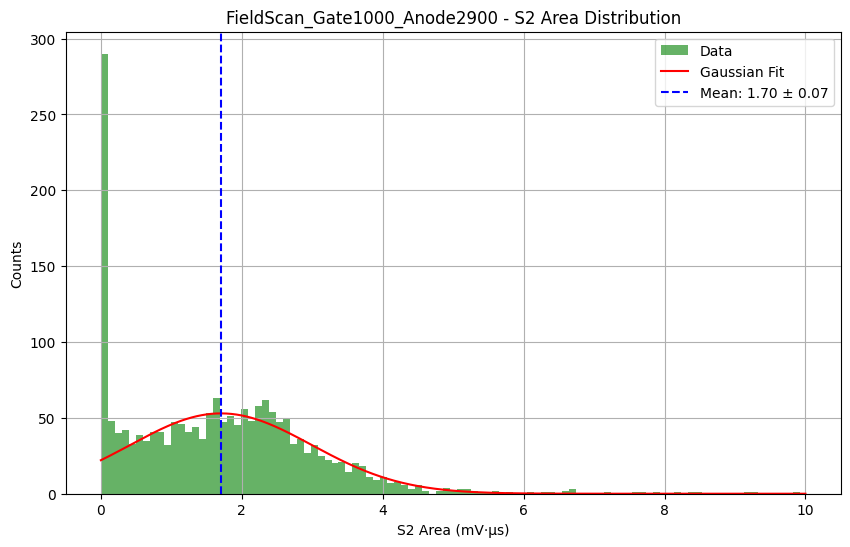

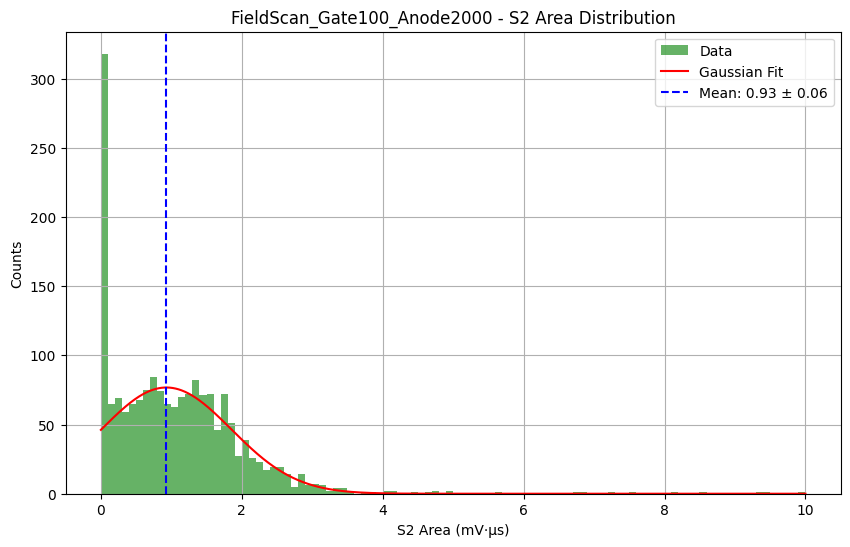

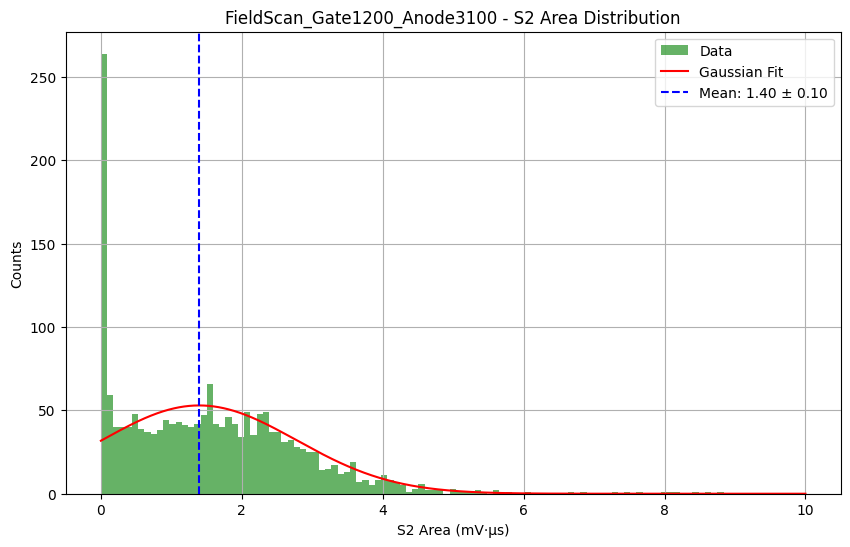

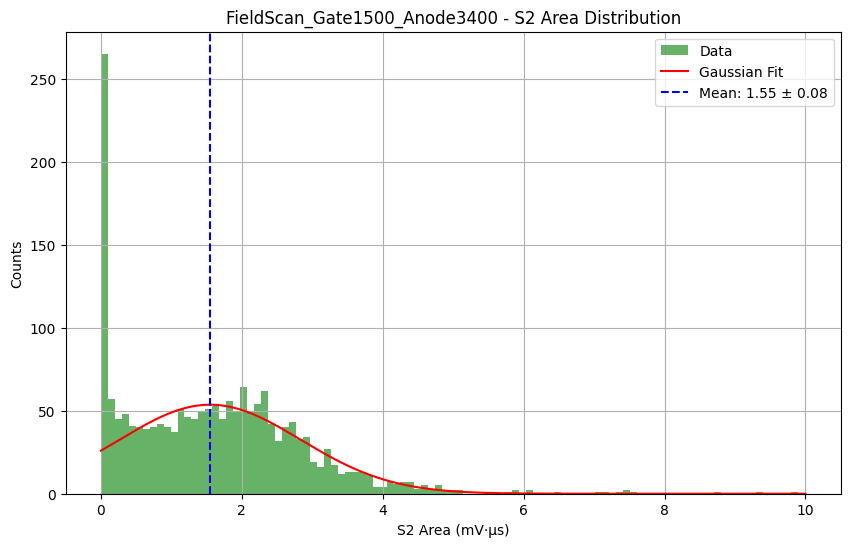

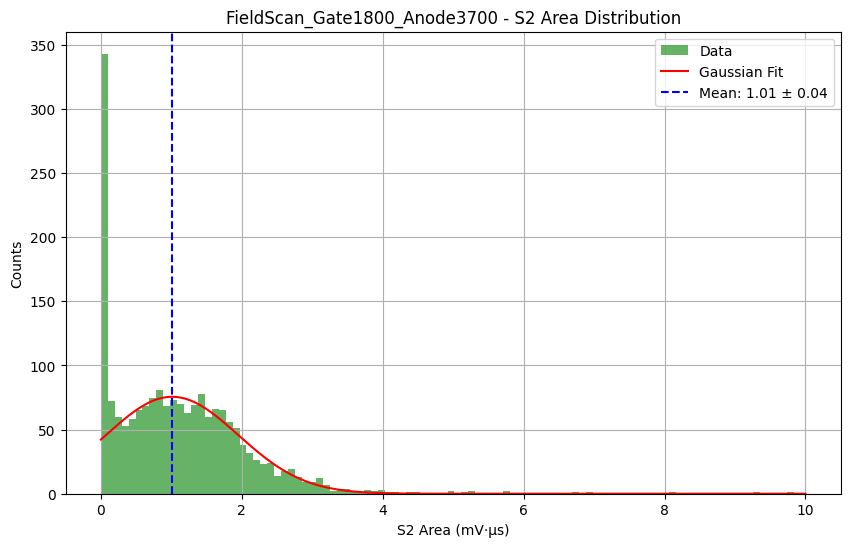

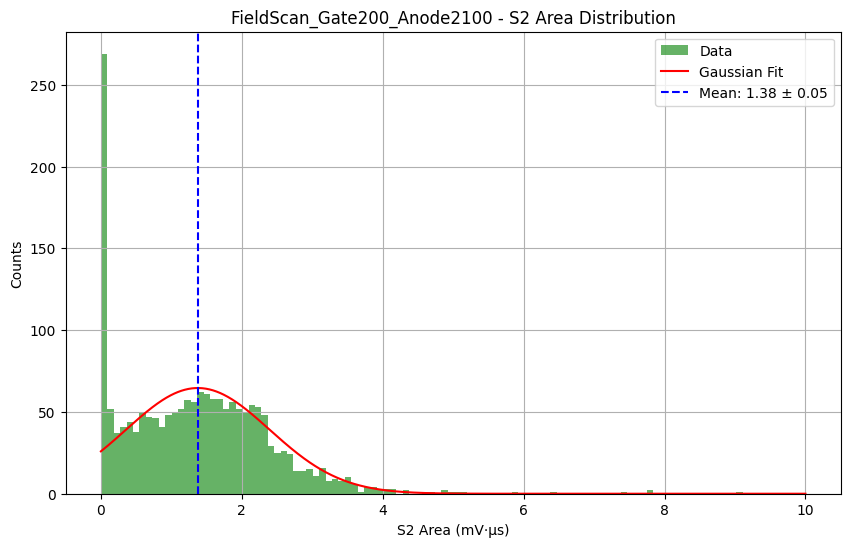

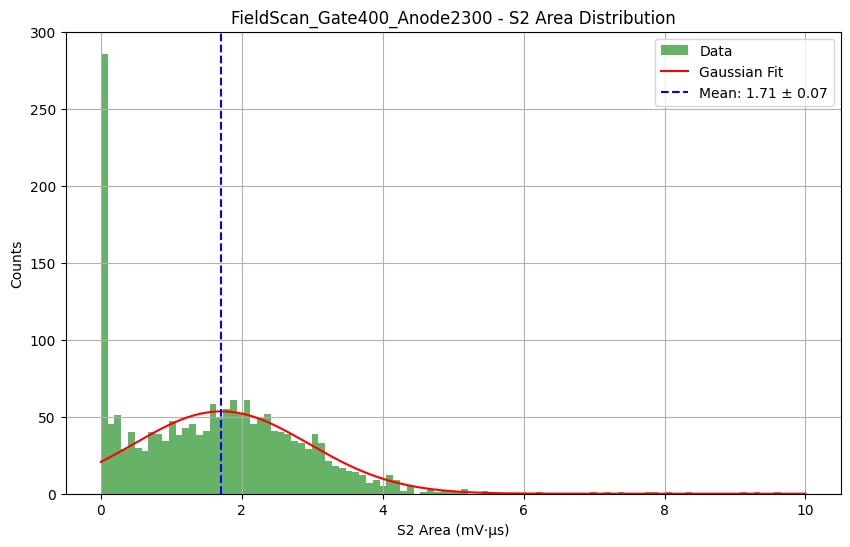

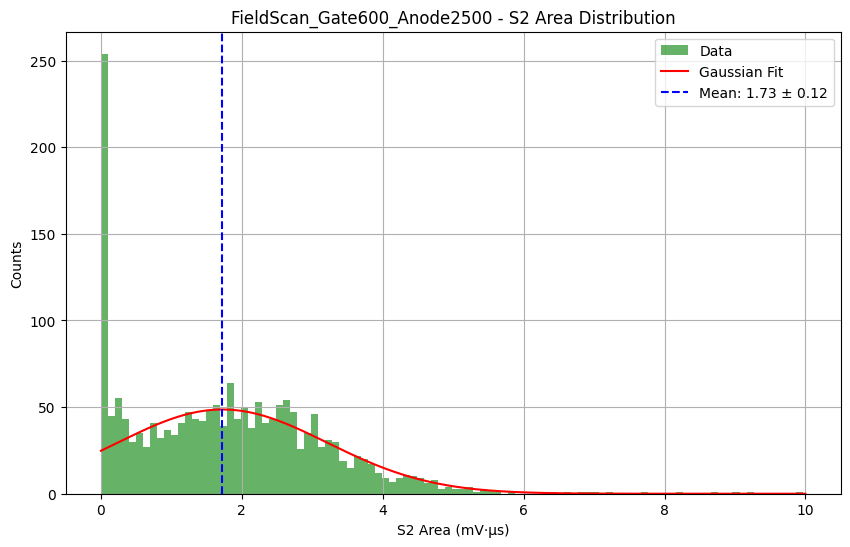

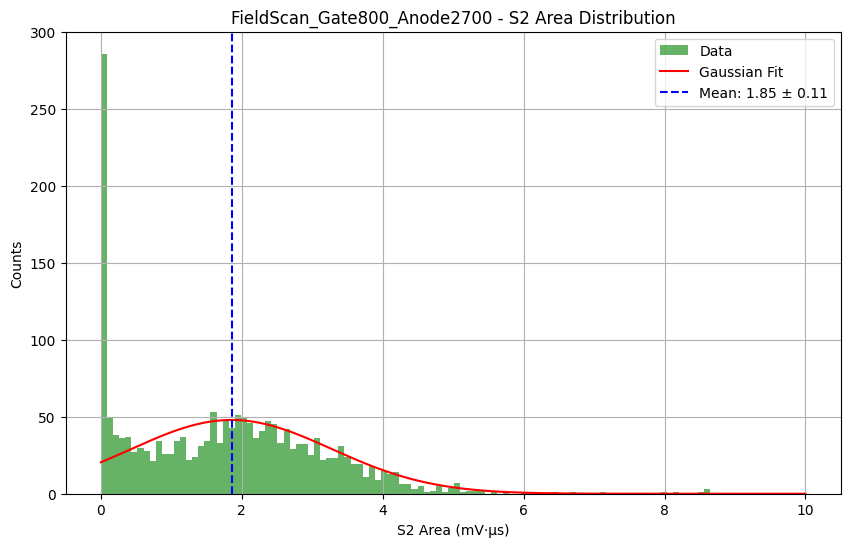

In [59]:
# Show individual histograms with fits
for set_name, fit in list(s2_fitted.items())[:]:  # Show first 3 sets
    fig, ax = plotting.plot_hist_fit(fit, nbins=fit_config.nbins, bin_cuts=fit_config.bin_cuts)
    plt.title(f"{set_name} - S2 Area Distribution")
    plt.show()

## 5. Calibration and Recombination Analysis

Use X-ray data (saved during unified integration) to calibrate the energy scale and compute electron recombination fractions.

**This step loads X-ray data from disk** (saved in step 3).

**Time**: ~1 minute


CALIBRATION & RECOMBINATION ANALYSIS
Loading X-ray data from disk (saved by unified integration)...
CALIBRATION AND RECOMBINATION ANALYSIS

[1/5] Loading X-ray results...
  → FieldScan_Gate050_Anode1950: 178 accepted events
  → FieldScan_Gate1000_Anode2900: 224 accepted events
  → FieldScan_Gate100_Anode2000: 194 accepted events
  → FieldScan_Gate1200_Anode3100: 264 accepted events
  → FieldScan_Gate1500_Anode3400: 205 accepted events
  → FieldScan_Gate1800_Anode3700: 169 accepted events
  → FieldScan_Gate200_Anode2100: 231 accepted events
  → FieldScan_Gate400_Anode2300: 176 accepted events
  → FieldScan_Gate600_Anode2500: 124 accepted events
  → FieldScan_Gate800_Anode2700: 184 accepted events
  → Total: 1949 accepted X-ray events

[2/5] Fitting X-ray histogram...


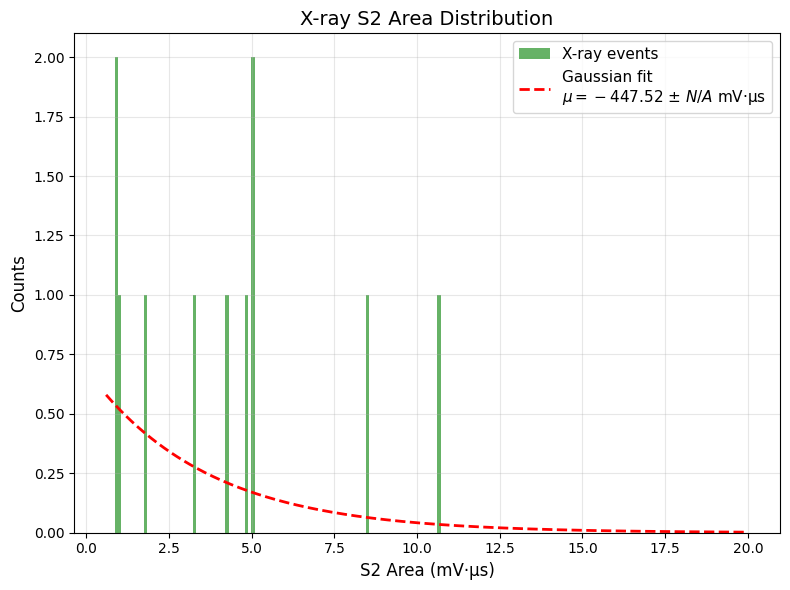

TypeError: unsupported format string passed to NoneType.__format__

In [62]:
# Run complete calibration analysis
calib_results, recomb_results = run_calibration_analysis_optimized(
    run10,
    ion_fitted_areas=s2_fitted,
    xray_bin_cuts=(0.6, 20),
    xray_nbins=100,
    flag_plot=True,
    save_plots=True
)

print("\n✓ Calibration analysis complete!")
print("✓ All plots saved to plots/ directory")

### Display Calibration Results

In [57]:
print("=" * 60)
print("CALIBRATION CONSTANTS")
print("=" * 60)
print(f"Run: {calib_results.run_id}")
print(f"X-ray mean area (A_x): {calib_results.A_x_mean:.3f} mV·µs")
print(f"Expected electrons (N_e_exp): {calib_results.N_e_exp:.1f}")
print(f"Gain factor (g_S2): {calib_results.g_S2:.4f} mV·µs/electron")
print()

CALIBRATION CONSTANTS
Run: RUN8
X-ray mean area (A_x): 4.391 mV·µs
Expected electrons (N_e_exp): 559.1
Gain factor (g_S2): 0.0079 mV·µs/electron



In [60]:
print("=" * 60)
print("RECOMBINATION vs DRIFT FIELD")
print("=" * 60)
for i, Ed in enumerate(recomb_results['drift_fields']):
    r = recomb_results['r'][i]
    dr = recomb_results['dr'][i]
    print(f"E_d = {Ed:6.1f} V/cm → r = {r:.3f} ± {dr:.3f}")

RECOMBINATION vs DRIFT FIELD
E_d =   35.7 V/cm → r = 1.030 ± 0.029
E_d =   71.4 V/cm → r = 0.859 ± 0.009
E_d =  142.9 V/cm → r = 0.763 ± 0.007
E_d =  214.3 V/cm → r = 0.710 ± 0.008
E_d =  285.7 V/cm → r = 0.667 ± 0.010
E_d =  357.1 V/cm → r = 0.635 ± 0.009
E_d =  428.6 V/cm → r = 0.604 ± 0.010


### Visualize Calibration Results

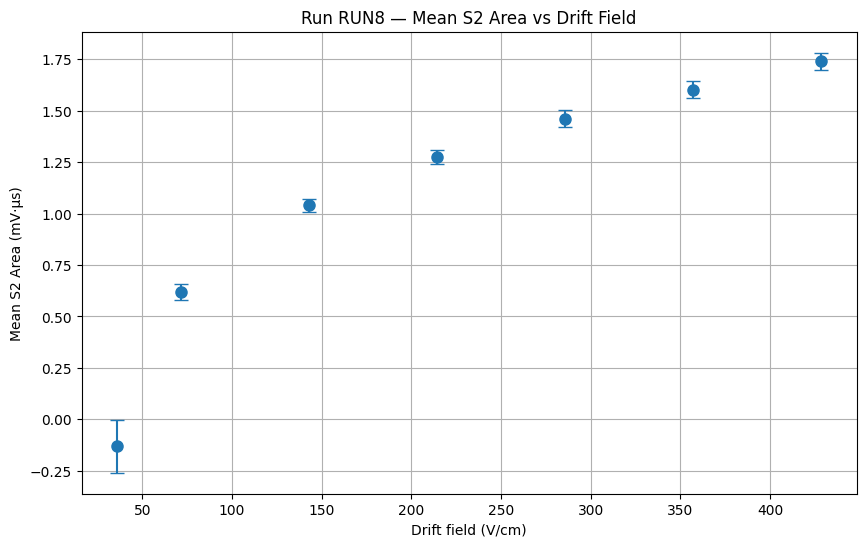

In [61]:
# Plot normalized S2 vs drift field (shows recombination)
fig, ax = plotting.plot_s2_vs_drift(run8, s2_fitted, normalized=True)
plt.show()

## 6. Time Comparison Summary

Let's review the time savings:

| Step | Old Pipeline | Optimized Pipeline | Speedup |
|------|-------------|-------------------|---------|
| Prepare run | ~30 min (all wfms) | ~5 min (2k wfms) | **6×** |
| X-ray classification | ~2 hours | - | - |
| S2 integration | ~2 hours | - | - |
| **Unified integration** | - | **~2 hours** | **2×** |
| S2 fitting | ~1 min | ~1 min | 1× |
| Calibration | ~1 min | ~1 min | 1× |
| **TOTAL** | **~4.5 hours** | **~2.1 hours** | **2.1×** |

**Key insight**: By processing each waveform only once for both X-ray and S2, we cut the processing time in half!

## 7. Export Results (Optional)

In [ ]:
# Package all results
results_dict = {
    'calibration': {
        'run_id': calib_results.run_id,
        'A_x_mean': calib_results.A_x_mean,
        'N_e_exp': calib_results.N_e_exp,
        'g_S2': calib_results.g_S2,
    },
    'recombination': {
        'drift_fields': recomb_results['drift_fields'],
        'recombination': recomb_results['recombination'],
        'recombination_uncertainty': recomb_results['recombination_uncertainty'],
    },
    's2_fits': {
        set_name: {
            'mean': fit.mean,
            'sigma': fit.sigma,
            'ci95': fit.ci95,
            'fit_success': fit.fit_success
        }
        for set_name, fit in s2_fitted.items()
    }
}

# Uncomment to save
# import pickle
# output_file = base_dir / f'{run8.run_id}_analysis_results_optimized.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(results_dict, f)
# print(f"✓ Results saved to {output_file}")

## Summary

This notebook demonstrated the **optimized unified pipeline** with significant performance improvements:

### ✅ Completed Steps

1. ✅ **Prepare Run** (~5 min) - Fast S2 window estimation with only 2k waveforms
2. ✅ **Unified Integration** (~2 hours) - X-ray + S2 in single pass
3. ✅ **S2 Fitting** (~1 min) - Fast post-processing
4. ✅ **Calibration** (~1 min) - Energy scale and recombination

### 🎯 Key Benefits

- **~50% faster** - 2.1 hours instead of 4.5 hours
- **Same results** - Identical output to original pipeline
- **Same files** - Fully compatible with existing tools
- **Less code** - Simpler workflow with unified integration

### 📁 Output Files

All results saved to run directory:
- Per-set: `xray_results.json`, `xray_areas.npy`, `s2_areas.npy`, `s2_results.json`
- Plots: `plots/{set_name}_s2_histogram.png`, `plots/{set_name}_waveform_validation.png`
- Run-level: `plots/{run_id}_s2_vs_drift.png`, `plots/{run_id}_xray_histogram.png`, etc.

### 🧪 Testing Tip

For quick testing, set `nfiles=10` in the integration step to process only 10 files per set (~2 minutes total).

---

**Documentation**: See `UNIFIED_INTEGRATION_OPTIMIZATION.md` for technical details.